# FluxRETAP Results

This notebook uses FluxRETAP to simulate genetic targets for a variety of organisms and products. 

The results are compared to previous literature examples.

# Setup
The first step to use this notebook is to make sure that the required dependencies are installed.
* cobra
* scipy
* pandas
* numpy
* matplotlib

if the packages are not installed, you can use the following line from the command prompt to install:
> pip install cobra scipy pandas numpy matplotlib

## Imports

Imports for basic functionality:

In [1]:
import cobra
from cobra import Reaction, Metabolite
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

And here we load the FluxRETAP library, make sure you have the right path in libraryPath:

In [2]:
libraryPath = "../../FluxRETAP"
sys.path.append(libraryPath)

from core.FluxRETAP import FluxRETAP

You are using cobra version:  0.22.0


## Auxiliary functions

This is an auxiliary function for comparing reactions identified in papers vs FluxRETAP:

In [3]:
def pieChart(labels, paper, output, count):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    sizes = [paper, output]
    explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    # Pie chart 
    fig1, ax1 = plt.subplots(1,2,figsize=(10,5))
    ax1[0].pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p*sum(sizes)/100 :.0f} Reactions',#autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1[0].title.set_text('Number of genes returned')
    sizes = [paper-count, count]

    
    labels = 'Uncaptured', 'Captured'
    ax1[1].title.set_text('Number of genes captured compared to previous method')

    ax1[1].pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p*sum(sizes)/100 :.0f} Reactions',
            shadow=True, startangle=90)
    ax1[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    fig1.figsize = (20,5)

    plt.show()

# Test 1 - Isoprenol production in E. coli

Our first comparison with experimental results involved CRISPRi targets chosen to increase isoprenol production in the [Tian 2019 study](https://pubs.acs.org/doi/pdf/10.1021/acssynbio.8b00429). These targets were chosen from central carbon metabolism by manually inspecting the metabolic map and choosing the reactions that may affect acetyl-coA supply: 

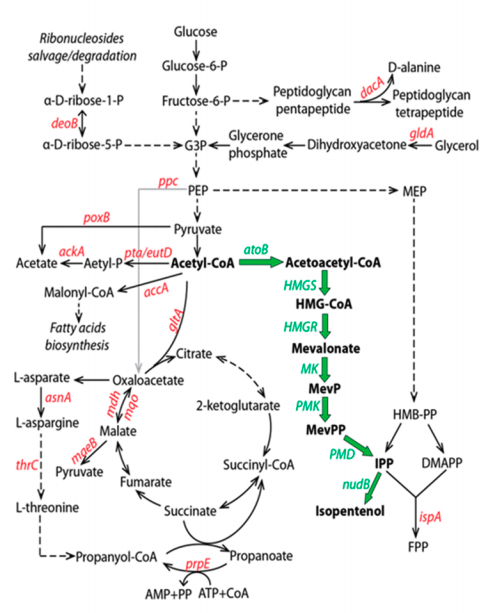

In [4]:
Image(libraryPath+"/images/"+"ECIsoprenolMap.png")

This produced twenty candidates, out of which eight improved isoprenol production over the base strain:

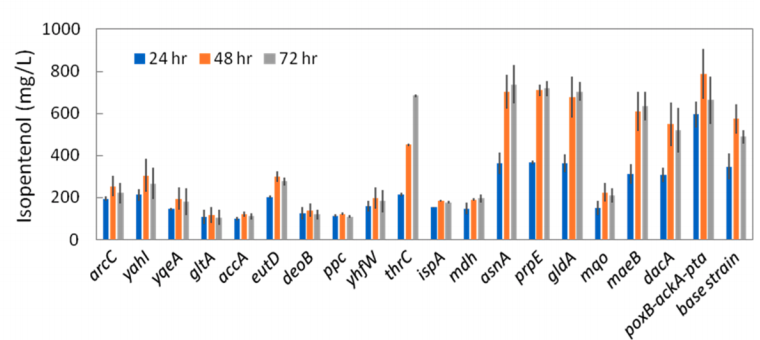

In [5]:
Image(libraryPath+"/images/"+"ECIsoprenolProduction.png")

In [6]:
# here are the gene modifications that improved isoprenol production over the base strain.
worked_genes = ['gldA','asnA','thrC','maeB','acs','poxB','ackA','pta']  # prpE has been renamed as acs in iJO1366

In [7]:
len(worked_genes)

8

## Load genome-scale model

Here we load the iJO1366 E. coli genome-scale model:

In [8]:
# Load E. coli GSM iJO1366
# iJO1366_MVA -- isoprenol production integrated
file_name = libraryPath+'/models/iJO1366_MVA.json' 

# load the file (json format)
model = cobra.io.load_json_model(file_name)

And we choose metabolic subsystem in central carbon metabolism, as done in the paper above:

In [9]:
subsystems = ['Glycolysis/Gluconeogenesis','Citric Acid Cycle','Pyruvate Metabolism','Pentose Phosphate Pathway','Threonine and Lysine Metabolism','Alternate Carbon Metabolism','Pyruvate Metabolism','Glycerophospholipid Metabolism',
 'Methylglyoxal Metabolism','Alanine and Aspartate Metabolism','Oxidative Phosphorylation','Anaplerotic Reactions']

And these are the reactions involved in these genes that worked:

In [10]:
# store the reactions associated with the worked_genes
worked_reactions =set([])

# find the reactions associated with the individual genes
for gene in worked_genes:
    for rxn in model.reactions:
        if gene in rxn.gene_name_reaction_rule:
            worked_reactions.add(rxn.id)
            print(gene+':\t'+rxn.id)             

# convert worked_reactions from set to list            
worked_reactions = list(worked_reactions)

gldA:	ALR4x
gldA:	APPLDHr
gldA:	GLYCDx
gldA:	LALDO2x
asnA:	ASNS2
thrC:	4HTHRS
thrC:	THRS
maeB:	ME2
acs:	ACCOAL
acs:	ACS
poxB:	POX
ackA:	ACKr
pta:	PTA2
pta:	PTAr


In [11]:
worked_reactions

['APPLDHr',
 'GLYCDx',
 'ASNS2',
 'ME2',
 'POX',
 'THRS',
 'LALDO2x',
 'PTAr',
 'ACKr',
 'PTA2',
 'ACCOAL',
 'ALR4x',
 '4HTHRS',
 'ACS']

## Run FluxRETAP

Now we set some of the basic parameters for FluxRETAP

In [12]:
optimalFraction = 0.0
fluxRangeDiff = 0.0005
N=10
referenceCutOff = 440
biomassRxn = 'BIOMASS_Ec_iJO1366_core_53p95M'
uptakeRxn = 'EX_glc__D_e'
UpOrDown = 'Down'
Ors=True
minGrowth = -0.01

and run FluxRETAP for this case:

In [13]:
productRxn = 'EX_isoprenol_e'
isoprenol = FluxRETAP.getRecommendations(model=model,
                                   UpOrDown=UpOrDown,
                                   productRxn=productRxn,
                                   carbonSourceRxn=uptakeRxn,
                                   biomassRxn=biomassRxn,
                                   desiredSystems=subsystems,
                                   N=N, 
                                   referenceCutOff=referenceCutOff,
                                   optimalFraction=optimalFraction,
                                   fluxRangeDiff= fluxRangeDiff,
                                   minGrowth = minGrowth,
                                   Ors = Ors)

Fractions of flux: [0.0, 0.1, 0.9, 1.0]
Maximum flux to product: 8.242471042471054

starting FVA simulations . . .
25.0 % complete
50.0 % complete
75.0 % complete
100.0 % complete
--- 28.11250901222229 seconds ---

Calculating significance scores
##################
Your cuttoff score is 440
The median reaction score in the dataset is 449 and the average is 6225414330
##################



In [14]:
# display the output dataframe
isoprenol

,score,trend,ors?,ands?,subsystem,fluxDiff,FinalFlux,In,growth %,bgene,geneName
CYTBO3_4pp,1.080509e+10,Down,False,True,Oxidative Phosphorylation,3.039416,4.605405e-01,True,9.096063e-01,b0429 and b0430 and b0431 and b0432,"[cyoD, cyoC, cyoB, cyoA]"
DHDPS,2.970661e+09,Down,False,False,Threonine and Lysine Metabolism,0.036799,-9.777408e-16,True,4.882400e-16,b2478,[dapA]
THDPS,2.970661e+09,Down,False,False,Threonine and Lysine Metabolism,0.036799,3.157018e-14,True,-2.225492e-16,b0166,[dapD]
DAPE,2.970661e+09,Down,False,False,Threonine and Lysine Metabolism,0.036799,-4.050521e-16,True,0.000000e+00,b3809,[dapF]
DHDPRy,2.970661e+09,Down,False,False,Threonine and Lysine Metabolism,0.036799,-3.995153e-16,True,1.144296e-15,b0031,[dapB]
...,...,...,...,...,...,...,...,...,...,...,...
NADH18pp,4.452280e+02,Down,False,True,Oxidative Phosphorylation,1.333624,2.302703e-01,True,1.000000e+00,b2276 and b2277 and b2278 and b2279 and b2280 ...,"[nuoN, nuoM, nuoL, nuoK, nuoJ, nuoI, nuoH, nuo..."
NADH17pp,4.452280e+02,Down,False,True,Oxidative Phosphorylation,1.333624,2.302703e-01,True,1.000000e+00,b2276 and b2277 and b2278 and b2279 and b2280 ...,"[nuoN, nuoM, nuoL, nuoK, nuoJ, nuoI, nuoH, nuo..."
FRD3,4.452279e+02,Down,False,True,Citric Acid Cycle,1.333657,2.302703e-01,True,1.000000e+00,b4151 and b4152 and b4153 and b4154,"[frdD, frdC, frdB, frdA]"
FRD2,4.452181e+02,Down,False,True,Citric Acid Cycle,1.349937,2.302703e-01,True,1.000000e+00,b4151 and b4152 and b4153 and b4154,"[frdD, frdC, frdB, frdA]"


This returns ~370 recommendations:

In [15]:
# size of the dataframe, with rows representing the number of targets returned. 
isoprenol.shape

(385, 11)

Some returned reactions do not have a gene associated with them. Some genes are associated with multiple reactions. Here we will determine the number of unique gene targets that were returned. 

In [16]:
# unique genes object
unique_set = set()

# determine the unique genes
for sublist in isoprenol.geneName.values:
    unique_set.update(set(sublist))

# number of unique genetic targets
len(unique_set)

238

## Compare FluxRETAP and prior results


Here, we check if any of the worked genes were not included in the unique set. All of them were captured.

In [17]:
set(worked_genes) - unique_set

set()

plot the results in a piechart

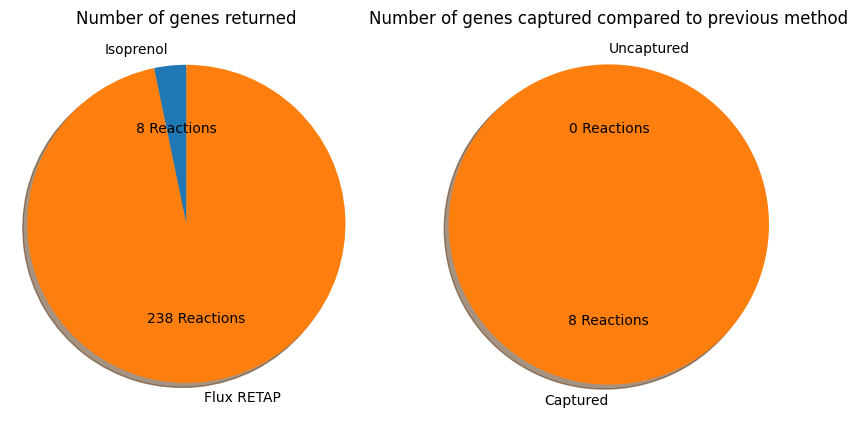

In [18]:
pieChart(['Isoprenol','Flux RETAP'], len(worked_genes),len(unique_set),len(worked_genes))

The first 50 recommendations comprised 4 out of those 8 genes, and the first 100 comprised 6 of those 8:

In [19]:
# new output dataframe with a reset index.
isoprenol2 = isoprenol.reset_index()

# obtain the index of the worked-genes in the output dataframe
worked_inds = isoprenol2['index']==worked_reactions[0]

for rxn in worked_reactions:
    worked_inds = worked_inds | (isoprenol2['index']==rxn)

In [20]:
# display the worked genes and their order in the dataframe
isoprenol2.loc[worked_inds]

,index,score,trend,ors?,ands?,subsystem,fluxDiff,FinalFlux,In,growth %,bgene,geneName
15,THRS,134852.327053,Down,False,False,Threonine and Lysine Metabolism,0.057528,4.684952e-13,True,-1.292640e-15,b0004,[thrC]
43,ACS,568.416302,Down,False,False,Pyruvate Metabolism,0.458109,4.938181e+01,True,1.000000e+00,b4069,[acs]
44,ACKr,568.323809,Down,True,False,Pyruvate Metabolism,0.385145,-4.938181e+01,True,1.000000e+00,b3115 or b2296 or b1849,"[tdcD, ackA, purT]"
45,PTAr,568.323809,Down,True,False,Pyruvate Metabolism,0.385145,4.938181e+01,True,1.000000e+00,b2297 or b2458,"[pta, eutD]"
83,GLYCDx,449.218066,Down,False,False,Alternate Carbon Metabolism,0.009474,-3.264266e-13,True,1.000000e+00,b3945,[gldA]
85,ALR4x,449.189302,Down,False,False,Glycerophospholipid Metabolism,0.000758,1.087500e-14,True,1.000000e+00,b3945,[gldA]
87,LALDO2x,449.177095,Down,False,False,Methylglyoxal Metabolism,0.000770,-5.015129e-16,True,1.000000e+00,b3945,[gldA]
97,ASNS2,449.084527,Down,False,False,Alanine and Aspartate Metabolism,0.023671,1.133056e-12,True,9.990012e-01,b3744,[asnA]
313,POX,449.035741,Down,False,False,Oxidative Phosphorylation,0.006767,3.284458e-15,True,1.000000e+00,b0871,[poxB]
373,ME2,448.718115,Down,False,False,Anaplerotic Reactions,0.015790,-3.167439e-15,True,1.000000e+00,b2463,[maeB]


# Test 2 - Taxadiene production in *E. coli*

Our second comparison with experimental results involved targets that were computational identified for over-expression in [Boghigian B et al. 2012.](https://link.springer.com/article/10.1007%2Fs00253-011-3725-1). These targets were selected via a combinations of MOMA and gene amplification. The targets were then experimentally tested. 


## Load and modify genome-scale model

### Load genome-scale model

In [21]:
# iAF1260 GSM utilized in publication
file_name = libraryPath+'/models/iAF1260.json' 

# load the file (json format)
model = cobra.io.load_json_model(file_name)

### Add heterologous reactions

as specified in the publication

Add the a geranylgeranyl diphosphate synthase reaction and corresponding metabolites:

In [22]:
GGPS = cobra.Reaction('GGPS')
GGPS.name = 'GGPS'
GGPS.subsystem = 'Cytosol'
GGPS.lower_bound = 0
GGPS.upper_bound = 1000

model.add_reactions([GGPS])  # add rxn to the model

Initialize the non-native metabolites: 

In [23]:
ggpp_c = cobra.Metabolite(
    'ggpp_c',
    formula ='',
    name = 'GGPP',
    compartment='c'
)

Add the stochiometrically balanced reaction to the model (note - the names are metabolites names as they appear in the GSM):

In [24]:
GGPS.add_metabolites({
    'frdp_c': -1,
    'ipdp_c': -1,
    'ppi_c': 1,
    ggpp_c: 1   
})

And next, we add the taxadiene production:

In [25]:
# initialize a rxn object and set the bounds
taxa = cobra.Reaction('taxa')
taxa.name = 'taxa'
taxa.subsystem = 'Cytosol'
taxa.lower_bound = 0
taxa.upper_bound = 1000

# add rxn to the model
model.add_reactions([taxa])

Again, we initialize the non-native metabolites:

In [26]:
taxadiene_c = cobra.Metabolite(
    'taxadiene_c',
    formula ='',
    name = 'Taxadiene',
    compartment='c'
)

taxa.add_metabolites({
    'ggpp_c': -1,
    'ppi_c': 1,
    taxadiene_c: 1   
})

We make taxadiene a demand reaction so it can accumulate inside the cell:

In [27]:
demand = model.add_boundary(model.metabolites.taxadiene_c,type="demand")

### Test model

Verify that the model can grow.

In [28]:
model.optimize()

,fluxes,reduced_costs
ACGAM1PPpp,0.000000,0.000000e+00
2AGPA140tipp,0.000000,-5.551115e-17
EX_acser_e,0.000000,0.000000e+00
2AGPA141tipp,0.000000,-5.551115e-17
2AGPA160tipp,0.000000,-5.551115e-17
...,...,...
UPP3MT,0.000164,-7.285839e-17
UPP3S,0.000329,0.000000e+00
GGPS,0.000000,-9.228322e-01
taxa,0.000000,0.000000e+00


We now ensure our results match that specified in the publication. The authors obtained a growth rate of 0.2671/h when using glycerol as the subtrate at 3 mmol/g/DCW

In [29]:
model.reactions.EX_glc__D_e.bounds=0,0
model.reactions.EX_glyc_e.bounds = -3,1000

amino_acids = ['EX_ala__L_e',
               'EX_gly_e',
               'EX_val__L_e',
               'EX_leu__L_e',
               'EX_ile__L_e',
               'EX_pro__L_e',
               'EX_his__L_e',
               'EX_thr__L_e',
               'EX_ser__L_e',
               'EX_phe__L_e',
               'EX_met__L_e',
               'EX_glu__L_e',
               'EX_gln__L_e',
               'EX_asp__L_e',
               'EX_asn__L_e',
               'EX_arg__L_e',
               'EX_cys__L_e',
               'EX_trp__L_e',
               'EX_tyr__L_e',
               'EX_lys__L_e']
for i in amino_acids:
    model.reactions.get_by_id(i).lower_bound = -0.1

Our growth should match. 0.2671/h:

In [30]:
model.optimize()

,fluxes,reduced_costs
ACGAM1PPpp,0.000000,0.000000e+00
2AGPA140tipp,0.000000,0.000000e+00
EX_acser_e,0.000000,0.000000e+00
2AGPA141tipp,0.000000,0.000000e+00
2AGPA160tipp,0.000000,-1.110223e-16
...,...,...
UPP3MT,0.000060,1.045171e-16
UPP3S,0.000119,0.000000e+00
GGPS,0.000000,-1.155558e+00
taxa,0.000000,0.000000e+00


## Run FluxRETAP

Let's initialize the parameters.

In [31]:
# set the relevant subsystems
subsystems = set()
for r in model.reactions:
    subsystems.add(r.subsystem)
    
# remove irrelevant subsystems
delete = ['Intracellular demand','Extracellular exchange','Biomass and maintenance functions','Intracellular source/sink']
subsystems = subsystems-set(delete)
subsystems.remove('')

In [32]:
subsystems = ['~ ','~Intracellular demand','~Extracellular exchange','~Biomass and maintenance functions','~Intracellular source/sink']

now run FluxRETAP with the following parameters:

In [33]:
uptakeRxn = 'EX_glyc_e'
UpOrDown = 'Up'
productRxn = 'taxa'
optimalFraction = 0.0
N=10
fluxRangeDiff = 0
biomassRxn = 'BIOMASS_Ec_iAF1260_core_59p81M'
referenceCutOff = 0
taxadiene = FluxRETAP.getRecommendations(model=model,
                                   UpOrDown=UpOrDown,
                                   productRxn=productRxn,
                                   carbonSourceRxn=uptakeRxn,
                                   biomassRxn=biomassRxn,
                                   desiredSystems=subsystems,
                                   N=N, 
                                   referenceCutOff=referenceCutOff,
                                   optimalFraction=optimalFraction,
                                   fluxRangeDiff=fluxRangeDiff)

Fractions of flux: [0.0, 0.1, 0.9, 1.0]
Maximum flux to product: 0.41727678571428434

starting FVA simulations . . .
25.0 % complete
50.0 % complete
75.0 % complete
100.0 % complete
--- 23.781200170516968 seconds ---

Calculating significance scores
##################
Your cuttoff score is 0
The median reaction score in the dataset is 450 and the average is 454004900145
##################



~60 reaction targets returned

In [34]:
# shape of the output dataframe. the rows are the number of reaction targets
taxadiene.shape

(63, 11)

Some returned reactions do not have a gene associated with them. Some genes are associated with multiple reactions. Here we will determine the number of unique gene targets that were returned. 

In [35]:
# create a new the output dataframe with reset index
taxadiene2 = taxadiene.reset_index()

taxadiene2 = taxadiene2.reset_index(drop=True)

# unique genes object
unique_set = set()

# determine the unique genes
for sublist in taxadiene2.geneName.values:
    unique_set.update(set(sublist))
    
# number of unique genetic targets
len(unique_set)

56

In the publication, 12 targets were computational identified. Of these, four were tested with three improving production. One additional target was rationally chosen and worked.



In [36]:
# for overexpression - (ppk, sthA worked)
paper_gene_targets_identified = ['ppk', 'sthA', 'purN', 'dxs', 'ispE', 'dxr','ispG','ispF','ispD','folD','ispH','ispA'] 

# experimentally worked
experimentally_worked = ['idi','ppk','sthA','purN']

Let's now find the reactions corresponding to the genes computational identified and experimentally verified:

In [37]:
worked_reactions     =set([])
identified_reactions =set([])

print('--------\ncomputationally identified targets below\n--------')

# for all identified targets (including those that did not work)
for gene in paper_gene_targets_identified:
    for rxn in model.reactions:
        if gene in rxn.gene_name_reaction_rule:
            identified_reactions.add(rxn.id)
            print(gene+':\t'+rxn.id)             

print('--------\nexperimentally verified genes below\n--------')
  
# genes for experimentally verified targets
for gene in experimentally_worked:
    for rxn in model.reactions:
        if gene in rxn.gene_name_reaction_rule:
            worked_reactions.add(rxn.id)
            print(gene+':\t'+rxn.id)

# convert sets to lists
worked_reactions = list(worked_reactions)
identified_reactions = list(identified_reactions)

--------
computationally identified targets below
--------
ppk:	PPK2
ppk:	PPK
sthA:	NADTRHD
purN:	GARFT
dxs:	DXPS
ispE:	CDPMEK
dxr:	DXPRIi
ispG:	MECDPDH2
ispF:	MECDPS
ispD:	MEPCT
folD:	MTHFC
folD:	MTHFD
ispH:	DMPPS
ispH:	IPDPS
ispA:	DMATT
ispA:	GRTT
--------
experimentally verified genes below
--------
idi:	IPDDI
ppk:	PPK2
ppk:	PPK
sthA:	NADTRHD
purN:	GARFT


## Compare FluxRETAP and prior results


Determine how many of the computational targets were captured.

In [38]:
set(paper_gene_targets_identified)-unique_set

{'folD', 'purN', 'sthA'}

In [39]:
len(paper_gene_targets_identified)-len(set(paper_gene_targets_identified)-unique_set)

9

9 out of the 12 were identified. 

One additional gene was tested that functioned - idi. 

experimentally verfiied targets

In [40]:
experimentally_worked

['idi', 'ppk', 'sthA', 'purN']

Determine how many experimentally targets were not captured

In [41]:
set(experimentally_worked) - unique_set

{'purN', 'sthA'}

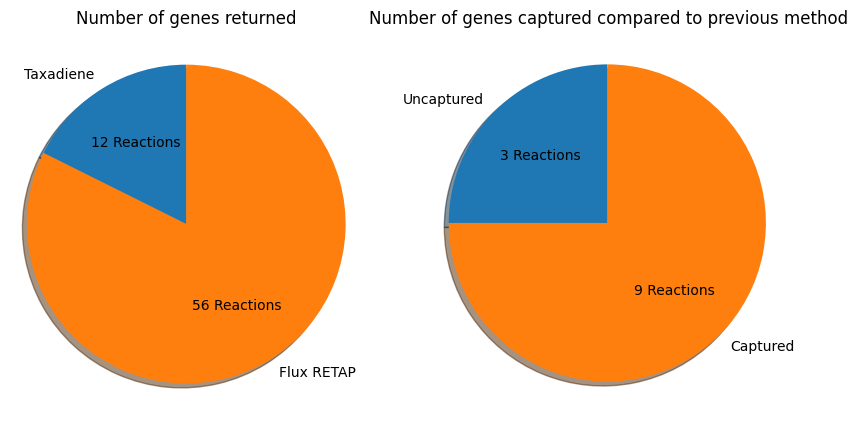

In [42]:
# plot the results in piecharts
pieChart(['Taxadiene','Flux RETAP'], len(paper_gene_targets_identified),len(unique_set),len(paper_gene_targets_identified)-len(set(paper_gene_targets_identified)-unique_set))

The computationally identified targets positions in the returned dataframe

In [43]:
# obtain the indeces of the computational identified targets
identified_inds = taxadiene2['index']==identified_reactions[0]
for rxn in identified_reactions:
    identified_inds = identified_inds | (taxadiene2['index']==rxn)

In [44]:
taxadiene2.loc[identified_inds]

,index,score,trend,ors?,ands?,subsystem,fluxDiff,FinalFlux,In,growth %,bgene,geneName
2,GRTT,1.449974e+11,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,1.390675e-01,1.390923e-01,True,1.499814e-13,b0421,[ispA]
3,DMATT,1.449974e+11,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,1.390675e-01,1.390923e-01,True,5.410024e-13,b0421,[ispA]
4,CDPMEK,1.449431e+11,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,5.561563e-01,5.563690e-01,True,1.909426e-13,b1208,[ispE]
5,DXPRIi,1.449431e+11,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,5.561563e-01,5.563690e-01,True,4.403339e-13,b0173,[dxr]
6,MEPCT,1.449431e+11,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,5.561563e-01,5.563690e-01,True,1.543926e-13,b2747,[ispD]
7,MECDPS,1.449431e+11,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,5.561563e-01,5.563690e-01,True,3.150869e-16,b2746,[ispF]
8,MECDPDH2,1.449431e+11,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,5.561563e-01,5.563690e-01,True,-1.722641e-13,b2515,[ispG]
9,DXPS,1.449241e+11,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,5.561166e-01,5.563690e-01,True,4.564033e-13,b0420,[dxs]
35,PPK,5.707333e+02,Up,False,False,Oxidative Phosphorylation,4.607624e-01,-1.666671e+05,True,9.880602e-01,b2501,[ppk]
47,DMPPS,4.492104e+02,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,2.780781e-01,2.781845e-01,True,1.000000e+00,b0029,[ispH]


The experimentally verified targets positions in the returned dataframe

In [45]:
# obtain the indeces of verfied gene targets
identified_inds_worked = taxadiene2['index']==worked_reactions[0]
for rxn in worked_reactions:
    identified_inds_worked = identified_inds_worked | (taxadiene2['index']==rxn)

In [46]:
taxadineIdentified = taxadiene2.loc[identified_inds_worked]

# display the dataframe
taxadineIdentified

,index,score,trend,ors?,ands?,subsystem,fluxDiff,FinalFlux,In,growth %,bgene,geneName
35,PPK,570.733303,Up,False,False,Oxidative Phosphorylation,4.607624e-01,-1.666671e+05,True,0.98806,b2501,[ppk]
59,IPDDI,416.696762,Up,False,False,Cofactor and Prosthetic Group Biosynthesis,1.390106e-01,-1.390923e-01,True,1.00000,b2889,[idi]
60,PPK2,406.007095,Up,False,False,Oxidative Phosphorylation,6.703457e-10,5.366618e-10,True,1.00000,b2501,[ppk]


In [47]:
# convert to dataframe for saving to csv
taxadineWorked = taxadiene2.loc[worked_inds]

# taxadineWorked.to_csv('Boghigian_2012_worked.csv')

# Test 3 - Indigoidine production in *P. putida*

Our third and final comparison involved examining targets returned from a minimal cut set that was tested in *P. putida*  for production of indigoidine in the [Banerjee 2020 study](https://www.nature.com/articles/s41467-020-19171-4#Sec20). The minimal cut set was partially implemented with CRISPRi and led to enhanced production. 


the following targets were computationally identified:

In [48]:
# target genes identified in all reaction sets. 
paper_targets_identified = ['PP_2082',
               'PP_1444',
               'PP_0654',
               'PP_1251',
               'PP_5085',
               'PP_2168',
               'PP_5176',
               'PP_0864',
               'PP_4947',
               'PP_5003',
               'PP_0434',
               'PP_4734',
               'PP_2925',
               'PP_5005',
               'PP_0751',
               'PP_0100']

In [49]:
len(paper_targets_identified)

16

## Load and modify genome-scale model

In [50]:
# model used iJN1463
file_name = libraryPath+'/models/iJN1463_modified.json' 

# load the file (json format)
model = cobra.io.load_json_model(file_name)

### Add heterologous production steps to the model

The next 5 cells below demonstrates how to add a non-native product. Two reactions are added:

- APNPT (creating indigoidine precursor)
- Indigoidine production

In [51]:
# initialize the APNPT reaction object and set the bounds
APNPT = Reaction('APNPT')
APNPT.name = 'ATP:pantetheine 4\'-phosphotransferase'
APNPT.subsystem = 'Cytosol'
APNPT.lower_bound = -1000
APNPT.upper_bound = 1000


# initialize the indigoidine reaction and set the bounds
product_rxn = Reaction('indigoidine_production')
product_rxn.name = 'Indigoidine production'
product_rxn.subsystem = 'Cytosol'
product_rxn.lower_bound = 0
product_rxn.upper_bound = 1000

In [52]:
# add to model
model.add_reactions([product_rxn,APNPT])

# initialize the non-native metabolites 
ptth_c = Metabolite(
    'ptth_c',
    formula='C11H22N2O4S',
    name='Pantetheine',
    compartment='c'
)



indigoidine_c = Metabolite(
    'indigoidine_c',
    formula ='C10H8N4O4',
    name = 'Indigoidine',
    compartment='c'
)

In [53]:
## add the stochiometrically balanced reaction to the model
# note - the names are metabolites names as they appear in the GSM
product_rxn.add_metabolites({
    'gln__L_c': -2,
    'atp_c': -2,
    'coa_c': -2,
    'fmn_c': -2,
    'o2_c': -2.5,
    'pap_c':2,
    'fmnh2_c': 2,
    'ppi_c': 2,
    'amp_c': 2,
    ptth_c: 2,
    'h2o_c': 1,
    'pi_c': 2,
    indigoidine_c: 1   
})

APNPT.add_metabolites({
    'atp_c': -1,
    ptth_c: -1,
    'adp_c': 1,
    'h_c':1,
    'pan4p_c':1
})

In [54]:
## allow the product to accumulate in the model 
# - allows for flux to flow through the reaction in silico
demand = model.add_boundary(model.metabolites.indigoidine_c,type="demand")

## Run FluxRETAP

Set the subsystems to examine. 

In [55]:
subsystems = set()
for r in model.reactions:
    subsystems.add(r.subsystem)

    
delete = ['Intracellular demand','Extracellular exchange','Biomass and maintenance functions','Intracellular source/sink']

subsystems = subsystems-set(delete)

In [56]:
subsystems = ['~ ','~Intracellular demand','~Extracellular exchange','~Biomass and maintenance functions','~Intracellular source/sink']

and run FluxRETAP with the following parameters:

In [57]:
uptakeRxn = 'EX_glc__D_e'
UpOrDown = 'Down'
productRxn = 'indigoidine_production'
optimalFraction = 0.5
N=10
fluxRangeDiff = 0
biomassRxn = 'BIOMASS_KT2440_WT3'
referenceCutOff = 0
indigoidine = FluxRETAP.getRecommendations(model=model,
                                   UpOrDown=UpOrDown,
                                   productRxn=productRxn,
                                   carbonSourceRxn=uptakeRxn,
                                   biomassRxn=biomassRxn,
                                   desiredSystems=subsystems,
                                   N=N, 
                                   referenceCutOff=referenceCutOff,
                                   optimalFraction=optimalFraction,
                                   fluxRangeDiff=fluxRangeDiff)

Fractions of flux: [0.0, 0.1, 0.9, 1.0]
Maximum flux to product: 1.5997530864197564

starting FVA simulations . . .
25.0 % complete
50.0 % complete
75.0 % complete
100.0 % complete
--- 32.673110008239746 seconds ---

Calculating significance scores
##################
Your cuttoff score is 0
The median reaction score in the dataset is 471 and the average is 9565400342
##################



~880 reactions are returned

In [58]:
indigoidine.shape

(893, 11)

Some returned reactions do not have a gene associated with them. Some genes are associated with multiple reactions. Here we will determine the number of unique gene targets that were returned. 

In [59]:
# create a new the output dataframe with reset index
indigoidine2 = indigoidine.reset_index()

indigoidine2 = indigoidine2.reset_index(drop=True)

# unique genes object
unique_set = set()

# determine the unique genes
for sublist in indigoidine2.geneName.values:
    unique_set.update(set(sublist))
    
# number of unique genetic targets
len(unique_set)

429

Let's now find the reactions corresponding to the genes in the minimal cut set from the publication:

In [60]:
# initialize object to hold reactions
identified_reactions =set([])

# find the reactions associated with the genes
for gene in paper_targets_identified:
    for rxn in model.reactions:
        if gene in rxn.gene_reaction_rule:
            identified_reactions.add(rxn.id)
            print(gene+':\t'+rxn.id)             

# convert set to list
identified_reactions = list(identified_reactions)

PP_2082:	PPS
PP_1444:	GLCDpp
PP_0654:	MDH
PP_1251:	MDH2
PP_1251:	DMALRED
PP_5085:	ME2
PP_2168:	TALA
PP_0864:	ORNDC
PP_4947:	P5CD
PP_4947:	PROD2
PP_4947:	PUTA3
PP_5003:	PHAP2C100
PP_5003:	PHAP2C101
PP_5003:	PHAP2C120
PP_5003:	PHAP2C121
PP_5003:	PHAP2C121d6
PP_5003:	PHAP2C140
PP_5003:	PHAP2C141
PP_5003:	PHAP2C141d5
PP_5003:	PHAP2C142
PP_5003:	PHAP2C60
PP_5003:	PHAP2C80
PP_5003:	PHAPC40
PP_5003:	PHAPC50
PP_5003:	PHAPC70
PP_5003:	PHAPC90
PP_5003:	PHAPCP100
PP_5003:	PHAPCP40
PP_5003:	PHAPCP50
PP_5003:	PHAPCP60
PP_5003:	PHAPCP70
PP_5003:	PHAPCP80
PP_5003:	PHAPCP90
PP_5003:	PHAPCT40
PP_5003:	PHAPCT60
PP_0434:	ANHMK
PP_2925:	MDH2
PP_2925:	DMALRED
PP_5005:	PHAP2C100
PP_5005:	PHAP2C101
PP_5005:	PHAP2C60
PP_5005:	PHAP2C80
PP_5005:	PHAPC40
PP_5005:	PHAPC50
PP_5005:	PHAPC70
PP_5005:	PHAPC90
PP_5005:	PHAPCP50
PP_5005:	PHAPCT40
PP_5005:	PHAPCT60
PP_0751:	MDH2
PP_0751:	DMALRED
PP_0100:	H2CO3D
PP_0100:	HCO3E


## Compare FluxRETAP and prior results


Determine number of genes not captured by the returned targets

In [61]:
paper_targets_identified

['PP_2082',
 'PP_1444',
 'PP_0654',
 'PP_1251',
 'PP_5085',
 'PP_2168',
 'PP_5176',
 'PP_0864',
 'PP_4947',
 'PP_5003',
 'PP_0434',
 'PP_4734',
 'PP_2925',
 'PP_5005',
 'PP_0751',
 'PP_0100']

In [62]:
# uncaptured targets
len(set(paper_targets_identified)-set(indigoidine.bgene))

7

7 out of 16 were not captured

In [63]:
# captured targets
len(set(paper_targets_identified))-(len(set(paper_targets_identified)-set(indigoidine.bgene)))

9

9 out of 16 were

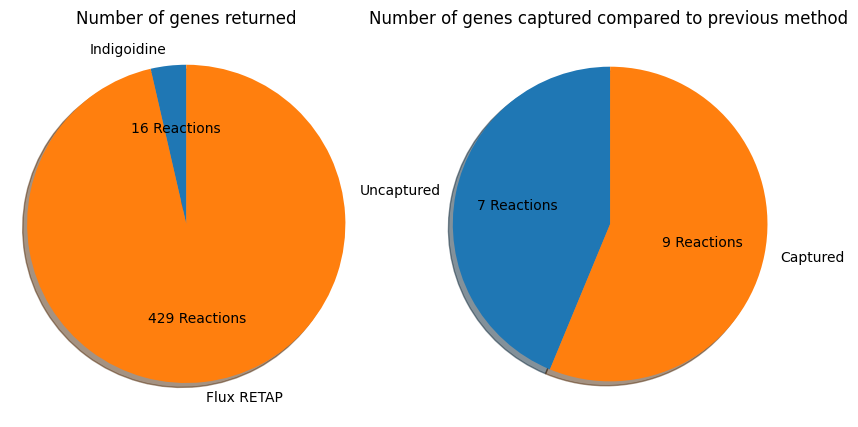

In [64]:
pieChart(['Indigoidine','Flux RETAP'], len(paper_targets_identified),len(unique_set),len(set(paper_targets_identified))-(len(set(paper_targets_identified)-set(indigoidine.bgene))))

identify indeces of the reactions in the returned target dataframe

In [65]:
# obtain the indeces of the computational identified targets
identified_inds = indigoidine2['index']==identified_reactions[0]
for rxn in identified_reactions:
    identified_inds = identified_inds | (indigoidine2['index']==rxn)
    


In [66]:
indigoidineIdentified = indigoidine2.loc[identified_inds]

# display the dataframe
indigoidineIdentified

,index,score,trend,ors?,ands?,subsystem,fluxDiff,FinalFlux,In,growth %,bgene,geneName
89,HCO3E,570.654590,Down,False,False,Unassigned,0.053895,5.713920e-02,True,1.000000,PP_0100,[cynT]
90,H2CO3D,570.654590,Down,False,False,Unassigned,0.053895,5.713920e-02,True,1.000000,PP_0100,[cynT]
92,MDH,570.302392,Down,False,False,S_TCA_Cycle,0.142875,8.345220e+01,True,0.990354,PP_0654,[mdh]
164,P5CD,470.546650,Down,False,False,S_Arginine_and_Proline_Metabolism,0.010798,6.267159e-13,True,1.000000,PP_4947,[putA]
184,PUTA3,470.546650,Down,False,False,S_Glutamate_Metabolism,0.010798,-2.580955e-12,True,1.000000,PP_4947,[putA]
225,PPS,470.546650,Down,False,False,S_Glycolysis,0.010798,-3.617867e-12,True,1.000000,PP_2082,[ppsA]
229,ORNDC,470.546650,Down,False,False,S_Arginine_and_Proline_Metabolism,0.003598,1.618617e-03,True,0.999700,PP_0864,[speC]
281,PROD2,470.546650,Down,False,False,S_Arginine_and_Proline_Metabolism,0.014398,-6.341222e-12,True,1.000000,PP_4947,[putA]
328,PHAPCP90,470.546650,Down,False,False,S_PHAs_Metabolism,0.010798,8.770587e-14,True,1.000000,PP_5003,[phaA]
349,PHAP2C140,470.546650,Down,False,False,S_PHAs_Metabolism,0.010798,1.169412e-13,True,1.000000,PP_5003,[phaA]


In [67]:
# convert to dataframe for saving to csv
# indigoidineIdentified.to_csv('Banerjee_2020_identified.csv')